# Steps Analysis (02/17/17 - 10/24/18)

In [31]:
from main_clean_function import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
df = main_clean_function('./data/export.xml')

Total Rows = 27660
Total Steps = 4952676
start_date != end_date: 139
Total Rows = 27660
Total Steps = 4952676
start_date != end_date: 139
Total Rows = 27801
Total Steps = 4952676.0
start_date != end_date: 0
Total Rows = 24904
Total Steps = 4599229.0
start_date != end_date: 0
Total Rows = 24901
Total Steps = 4316374.0
start_date != end_date: 0
Total Rows = 24900
Total Steps = 4316358.0
start_date != end_date: 0


In [123]:
df.columns

Index(['start_date', 'start_time', 'end_date', 'end_time', 'num_steps',
       'duration', 'source'],
      dtype='object')

In [147]:
summed_df = df.groupby(by=['start_date', 'end_date']).sum()
summed_df['steps_per_hour'] = summed_df['num_steps']/summed_df['duration']
summed_df.reset_index(inplace=True)

In [148]:
def drop_change_rename_df(df, x, col_rnm, drc=['start_time', 'end_time']):
    df.drop(df.index[list(range(x-1))], inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns=['index'])
    df.loc[:, 'start_date'] = df['end_date'] - pd.Timedelta(x, unit='D')
    df.rename(columns={'num_steps': col_rnm+'num_steps',
                       'duration': col_rnm+'duration'}, inplace=True)
    
    if type(drc) == list and len(drc) > 0:
        df.drop(columns=drc, inplace=True)
    df.drop(columns=['index', 'steps_per_hour'], inplace=True)
    print(df.columns)
    df.set_index(['start_date', 'end_date'], inplace=True)
    return df

In [149]:
def rolling_day_df(df, x):
    df.set_index(['start_date', 'end_date'], inplace=True)
    m_df = df.rolling(x).mean()
    m_df.reset_index(inplace=True)
    md_df = df.rolling(x).median()
    md_df.reset_index(inplace=True)
    std_df = df.rolling(x).std()
    std_df.reset_index(inplace=True)
    s_df = df.rolling(x).sum()
    s_df.reset_index(inplace=True)

    m_df = drop_change_rename_df(m_df, x, 'mean_')
    md_df = drop_change_rename_df(md_df, x, 'median_')
    std_df = drop_change_rename_df(std_df, x, 'std_')
    s_df = drop_change_rename_df(s_df, x, 'total_')
    
    merged_df_uno = pd.merge(m_df, md_df, on=m_df.index)
    merged_df_dos = pd.merge(std_df, s_df, on=std_df.index)
    merged_df_finale = pd.merge(merged_df_uno, merged_df_dos, on=merged_df_uno.index)
    return merged_df_finale

In [150]:
rolling_day_df(summed_df, 30)

Index(['start_date', 'end_date', 'mean_num_steps', 'mean_duration'], dtype='object')
Index(['start_date', 'end_date', 'median_num_steps', 'median_duration'], dtype='object')
Index(['start_date', 'end_date', 'std_num_steps', 'std_duration'], dtype='object')
Index(['start_date', 'end_date', 'total_num_steps', 'total_duration'], dtype='object')


,key_0,key_0_x,mean_num_steps,mean_duration,median_num_steps,median_duration,key_0_y,std_num_steps,std_duration,total_num_steps,total_duration
0,0,"(2017-02-16 00:00:00, 2017-03-18 00:00:00)",3105.566667,3.955833,2830.5,3.689306,"(2017-02-16 00:00:00, 2017-03-18 00:00:00)",1260.605976,1.218098,93167.0,118.675000
1,1,"(2017-02-17 00:00:00, 2017-03-19 00:00:00)",3170.600000,4.011278,2830.5,3.689306,"(2017-02-17 00:00:00, 2017-03-19 00:00:00)",1186.340638,1.115328,95118.0,120.338333
2,2,"(2017-02-18 00:00:00, 2017-03-20 00:00:00)",3172.633333,4.006509,2830.5,3.689306,"(2017-02-18 00:00:00, 2017-03-20 00:00:00)",1185.501479,1.119492,95179.0,120.195278
3,3,"(2017-02-19 00:00:00, 2017-03-21 00:00:00)",3188.633333,4.061972,2830.5,3.768750,"(2017-02-19 00:00:00, 2017-03-21 00:00:00)",1186.204480,1.135939,95659.0,121.859167
4,4,"(2017-02-20 00:00:00, 2017-03-22 00:00:00)",3223.800000,4.079102,2847.5,3.768750,"(2017-02-20 00:00:00, 2017-03-22 00:00:00)",1190.285083,1.141088,96714.0,122.373056
5,5,"(2017-02-21 00:00:00, 2017-03-23 00:00:00)",3186.400000,4.041972,2847.5,3.768750,"(2017-02-21 00:00:00, 2017-03-23 00:00:00)",1220.681991,1.172083,95592.0,121.259167
6,6,"(2017-02-22 00:00:00, 2017-03-24 00:00:00)",3192.000000,4.040185,2847.5,3.768750,"(2017-02-22 00:00:00, 2017-03-24 00:00:00)",1218.087081,1.173276,95760.0,121.205556
7,7,"(2017-02-23 00:00:00, 2017-03-25 00:00:00)",3223.133333,4.064435,2847.5,3.768750,"(2017-02-23 00:00:00, 2017-03-25 00:00:00)",1261.098283,1.206719,96694.0,121.933056
8,8,"(2017-02-24 00:00:00, 2017-03-26 00:00:00)",3236.200000,4.060991,2847.5,3.768750,"(2017-02-24 00:00:00, 2017-03-26 00:00:00)",1261.380508,1.205980,97086.0,121.829722
9,9,"(2017-02-25 00:00:00, 2017-03-27 00:00:00)",3113.333333,3.929648,2806.0,3.687083,"(2017-02-25 00:00:00, 2017-03-27 00:00:00)",1218.195538,1.156019,93400.0,117.889444


In [ ]:
# summed_df.rolling(30).std()

In [ ]:
# summed_df.rolling(7).std().min()

In [14]:
summed_df

,start_date,end_date,start_time,end_time,num_steps,duration,steps_per_hour
0,2017-02-17,2017-02-17,176.142778,177.204167,812.0,1.061389,765.035331
1,2017-02-18,2017-02-18,475.579722,478.716944,2668.0,3.137222,850.433859
2,2017-02-19,2017-02-19,570.570556,574.096111,2991.0,3.525556,848.376930
3,2017-02-20,2017-02-20,629.371389,633.515833,2812.0,4.144444,678.498660
4,2017-02-21,2017-02-21,531.381667,535.065833,2819.0,3.684167,765.166252
5,2017-02-22,2017-02-22,450.330278,453.641944,2559.0,3.311667,772.722698
6,2017-02-23,2017-02-23,623.042778,628.317778,4396.0,5.275000,833.364929
7,2017-02-24,2017-02-24,516.233333,520.597778,3060.0,4.364444,701.120163
8,2017-02-25,2017-02-25,875.944722,882.344444,5439.0,6.399722,849.880637
9,2017-02-26,2017-02-26,495.943056,499.372222,1592.0,3.429167,464.252734


In [35]:
summed_df.groupby(summed_df['start_date'].dt.strftime('%b%y'), sort=False).mean()

,start_time,end_time,num_steps,duration,steps_per_hour
start_date,,,,,
Feb17,507.158426,510.870718,2813.666667,3.712292,749.712815
Mar17,505.401201,509.511120,3263.129032,4.109919,786.410671
Apr17,559.060620,563.902139,3880.266667,4.841519,795.465096
May17,428.377348,432.273297,3285.774194,3.895950,810.074697
Jun17,672.682000,678.314278,6418.233333,5.632278,1072.314114
Jul17,737.535170,743.151864,5750.516129,5.616694,968.077474
Aug17,561.261729,566.080556,4210.096774,4.818826,855.252504
Sep17,704.341724,709.808803,5991.379310,5.467079,1055.748252
Oct17,714.263575,720.476514,7442.451613,6.212939,1216.381406


In [22]:
summed_df.num_steps.std()

3417.721334046622

In [23]:
print_remainder(df)

Total Rows = 24897
Total Steps = 4316271.0
start_date != end_date: 0


In [ ]:
X = summed_df.start_date.values
y = df.num_steps.values
type(y)

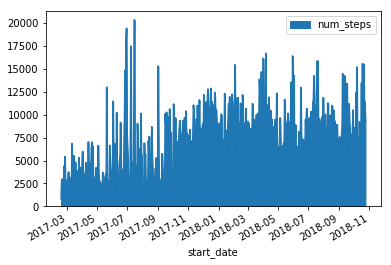

In [46]:
summed_df.plot(x='start_date', y='num_steps', kind='area')

In [ ]:
summed_df.min()